In [2]:
# Third-party
from astropy.io import fits, ascii
import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
allstar = fits.getdata('/Users/adrian/data/APOGEE_DR16/allStar-r12-l33.fits')

In [4]:
sun_mask = ((np.abs(allstar['LOGG'] - 4.44) < 0.1) &
            (allstar['TEFF'] > 5677) & ((allstar['TEFF'] < 5877)))

In [5]:
sun_mask.sum()

5395

In [ ]:
allstar['C_FE']

In [3]:
mask = (allstar['LOGG'] > 4.) & (allstar['M_H'] > -2.) & (allstar['C_FE'] > -1)

In [38]:
starflag_mask = np.sum(2 ** np.array([9, 12, 13, # PERSIST_HIGH, PERSIST_JUMP_POS, PERSIST_JUMP_NEG
                                      3, 4])) # VERY_BRIGHT_NEIGHBOR, LOW_SNR
aspcap_mask = np.sum(2 ** np.array([7, 23])) # STAR_WARN, STAR_BAD

mask = (((allstar['ASPCAPFLAG'] & aspcap_mask) == 0) &
        ((allstar['STARFLAG'] & starflag_mask) == 0) &
        (allstar['FE_H'] > -999) &
        (allstar['C_FE'] > -999) &
        (allstar['N_FE'] > -999) & 
        (allstar['O_FE'] > -999) & 
        (allstar['AL_FE'] > -999) &
        (allstar['NI_FE'] > -999) &
        (allstar['LOGG'] > 4.5) & 
        (allstar['TEFF'] > 3500) & (allstar['TEFF'] < 7000) &
        (allstar['M_H'] > -1.))
        
stars = Table(allstar[mask])
len(stars)

22063

In [5]:
per_Fe_names = []
for name in stars.dtype.names:
    if '_FE' in name and '_ERR' not in name and 'FEH' not in name and 'FLAG' not in name:
        per_Fe_names.append(name)
per_Fe_names = np.array(per_Fe_names)
per_Fe_names

array(['C_FE', 'CI_FE', 'N_FE', 'O_FE', 'NA_FE', 'MG_FE', 'AL_FE',
       'SI_FE', 'P_FE', 'S_FE', 'K_FE', 'CA_FE', 'TI_FE', 'TIII_FE',
       'V_FE', 'CR_FE', 'MN_FE', 'CO_FE', 'NI_FE', 'CU_FE', 'GE_FE',
       'RB_FE', 'CE_FE', 'ND_FE', 'YB_FE'], dtype='<U7')

In [6]:
# Note: more correct? https://github.com/megbedell/q2/blob/master/abundances.py
lodders = ascii.read('../trendyapogee/data/Lodders2003.txt', delimiter=',')
lodders['elem'] = [n.lower() for n in lodders['elem']]
lodders = lodders[np.argsort(lodders['elem'])]

In [7]:
per_Fe_Tc = []
good_Tc = []
for i, name in enumerate(per_Fe_names):
    _name = name.lower().split('_')[0]
    Tc = lodders['Tc_50'][lodders['elem'] == _name]
    if len(Tc) == 0: 
        per_Fe_Tc.append(np.nan)
    else:
        per_Fe_Tc.append(Tc[0])
    
per_Fe_Tc = np.array(per_Fe_Tc)

In [8]:
elem_names = np.append(per_Fe_names[np.isfinite(per_Fe_Tc)], 'FE_H')
elem_Tc = np.append(per_Fe_Tc[np.isfinite(per_Fe_Tc)], 1334.0)

In [33]:
elem_names[elem_Tc.argsort()]

array(['C_FE', 'N_FE', 'O_FE', 'S_FE', 'RB_FE', 'GE_FE', 'NA_FE', 'K_FE',
       'CU_FE', 'MN_FE', 'P_FE', 'CR_FE', 'FE_H', 'SI_FE', 'MG_FE',
       'CO_FE', 'NI_FE', 'V_FE', 'YB_FE', 'CE_FE', 'CA_FE', 'TI_FE',
       'ND_FE', 'AL_FE'], dtype='<U7')

In [40]:
x = elem_Tc
all_y = np.zeros((len(stars), len(elem_names)))
all_err = np.zeros((len(stars), len(elem_names)))

for i, name in enumerate(elem_names):
    all_y[:, i] = stars[name] - stars['FE_H']
    all_err[:, i] = np.sqrt(stars[name + '_ERR']**2 + stars['FE_H_ERR']**2)
    stars['{}_H'.format(name.split('_')[0])] = all_y[:, i]

all_y.shape

(22063, 24)

In [50]:
i = 4

star = stars[i]
star_mask = ((np.abs(star['TEFF'] - stars['TEFF']) < 100) & 
             (np.abs(star['LOGG'] - stars['LOGG']) < 0.05) & 
             (np.abs(star['SNR'] - stars['SNR']) < 20) & 
             (np.abs(star['C_H'] - stars['C_H']) < 0.05) &
             (np.abs(star['N_H'] - stars['N_H']) < 0.05) &
             (np.abs(star['AL_H'] - stars['AL_H']) > 0.1) & 
             (np.abs(star['NI_H'] - stars['NI_H']) > 0.1) & 
             (np.abs(star['MG_H'] - stars['MG_H']) > 0.1) & 
             # (np.abs(star['FE_H'] - stars['FE_H']) < 0.02) & 
             (star['APOGEE_ID'] != stars['APOGEE_ID']))
star_mask.sum()

4

Text(0,0.5,'$\\Delta$[X/H]')

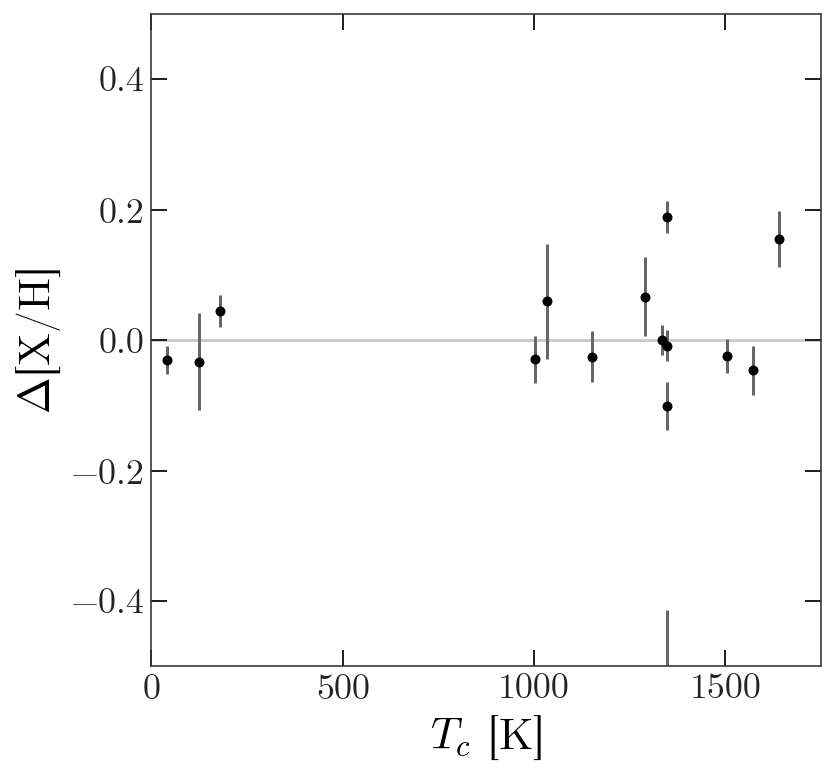

In [54]:
j = 0
other_star = all_y[star_mask][j]

plot_mask = (all_y[i] > -999) & (all_y[star_mask][j] > -999)
plt.errorbar(x[plot_mask], 
             (all_y[i] - all_y[star_mask][j])[plot_mask],
             yerr=np.sqrt(all_err[i]**2 + all_err[star_mask][0]**2)[plot_mask],
             ls='none', marker='o', color='k', ecolor='#666666')
plt.xlim(0, 1750)
plt.ylim(-0.5, 0.5)
plt.axhline(0, color='#cccccc', zorder=-100, marker='')
plt.xlabel('$T_c$ [K]')
plt.ylabel(r'$\Delta$[X/H]')

--- 

### Look for Kronos/Krios analog?

In [57]:
from tqdm import tqdm

In [61]:
all_dfeh = []
for i, star in tqdm(enumerate(stars), total=len(stars)):
    star_mask = ((np.abs(star['TEFF'] - stars['TEFF']) < 100) & 
                 (np.abs(star['LOGG'] - stars['LOGG']) < 0.1) & 
                 (stars['SNR'] > 150) & 
                 (star['APOGEE_ID'] != stars['APOGEE_ID']))
    
    dC = star['C_H'] - stars['MG_H']
    dN = star['N_H'] - stars['MG_H']
    dO = star['O_H'] - stars['MG_H']
    CNO_mask = (np.abs(dC) < 0.05) & (np.abs(dN) < 0.05) & (np.abs(dO) < 0.05)
    
    metal_lim = 0.05
    dMg = star['MG_H'] - stars['MG_H']
    dNi = star['NI_H'] - stars['NI_H']
    dTi = star['TI_H'] - stars['TI_H']
    dAl = star['AL_H'] - stars['AL_H']
    metal_mask = ((np.abs(dMg) > metal_lim) & (np.abs(dNi) > metal_lim) & 
                  (np.abs(dTi) > metal_lim) & (np.abs(dAl) > metal_lim) &
                  (np.abs(dNi) == np.sign(dMg)) & (np.abs(dTi) == np.sign(dMg)) &
                  (np.abs(dAl) == np.sign(dMg)))
    
    all_mask = star_mask & CNO_mask & metal_mask
    
    if all_mask.sum():
        print('yo!')
        break
                  
    
    all_dfeh.append(star['FE_H'] - stars['FE_H'])
    continue
    
    if star_mask.sum():
        other_stars = all_y[star_mask]

        null_mask = (all_y[i][None] > -999) & (all_y[star_mask] > -999)
        dy = all_y[i][None] - all_y[star_mask]
        dy_err = np.sqrt(all_err[i][None]**2 + all_err[star_mask]**2)

        CNO_mask = np.all(np.abs(dy[:, :3]) < 3*dy_err[:, :3], axis=1)

        for j in range(dy.shape[0]):
            plt.errorbar(x[null_mask[j]], dy[j, null_mask[j]], yerr=dy_err[j, null_mask[j]],
                         ls='none', marker='o')
        plt.xlim(0, 1750)
        plt.ylim(-0.5, 0.5)
        plt.axhline(0, color='#cccccc', zorder=-100, marker='')
        plt.xlabel('$T_c$ [K]')
        plt.ylabel(r'$\Delta$[X/H]')

        break

100%|██████████| 22063/22063 [01:13<00:00, 300.25it/s]
